In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import info_ReadDichotomous
import datasinca_v1 as d
import Info_Visualizing_SINCA as sinca
from matplotlib.offsetbox import AnchoredText
from scipy.stats import lognorm
import math
from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import leastsq

In [49]:
df = pd.DataFrame() 

for i in [1988,1989]:
    #print(i)
    var=info_ReadDichotomous.leer_dico0(str(i))
    df=pd.concat([df,var])
df1=df

df2 = pd.DataFrame() 
for i in range(1990,2017):
    #print(str(i))
    var=info_ReadDichotomous.leer_dico1(str(i)) 
    df2 = pd.concat([df2,var])

df=pd.concat([df,df2])

data_2017 = info_ReadDichotomous.leer_dico2('2017')
data_2018 = info_ReadDichotomous.leer_dico2('2018')
data_2019 = info_ReadDichotomous.leer_dico2('2019')
data_2020 = info_ReadDichotomous.leer_dico2('2020')
df3=pd.concat([data_2017,data_2018,data_2019,data_2020],axis=0)

df=pd.concat([df,df3],axis=0)

#EMF : Independencia
#EMN : Parque Ohiggins
#EMM : Las Condes

In [50]:
def filtro_dico(df):
    pos_aux = df < 5
    df[pos_aux] = np.nan
    return df

In [51]:
df = filtro_dico(df)

In [52]:
# 3 estaciones en un mismo df para histograma
dico25= pd.concat([df.iloc[:,0], df.iloc[:,2],df.iloc[:,4]])
dico10= pd.concat([df.iloc[:,1], df.iloc[:,3],df.iloc[:,5]])

In [53]:
def leer_sinca(Filename):
    dodo=open(Filename,'r')
    col_count = [ len(l.split(",")) for l in dodo.readlines() ]
    column_names = ['Validados','Preliminares','No validados','']
    data = pd.read_csv(Filename,header = None,names=column_names,sep='\;')
    dates = pd.date_range('1997-01-01-00', '2020-12-31-23', freq='H')
    
    Validados = pd.to_numeric(pd.Series(data['Validados'].values, index=dates), errors='coerce')
    Preliminares = pd.to_numeric(pd.Series(data['Preliminares'].values, index=dates), errors='coerce')
    No_Validados = pd.to_numeric(pd.Series(data['No validados'].values, index=dates), errors='coerce')
    
    df_data = pd.DataFrame({'Validados':Validados, 'Preliminares':Preliminares,'No validados':No_Validados})
    return df_data

In [54]:
def completitud(df, n, frec):
    bad_mean  = np.isnan(df).astype(int).resample(frec).sum()
    m         = 24 #np.isnan(df).astype(int).resample(frec).sum().max()
    good_mean = bad_mean > m-n
    count_bad = good_mean.sum()
    df_hourly = df.resample(frec).mean()
    df_hourly[good_mean] = np.nan
    return [df_hourly, count_bad]

In [79]:
LC = sinca.acopla_series_aerosol('Las Condes','1997-01-01-01','2020-12-31-23')
IN = sinca.acopla_series_aerosol('Independencia','1997-01-01-01','2020-12-31-23')
PO = sinca.acopla_series_aerosol('Parque Ohiggins','1997-01-01-01','2020-12-31-23')

Las Condes
Independencia
Parque Ohiggins


In [80]:
LC = completitud(LC,18,'D')[0]
IN = completitud(IN,18,'D')[0]
PO = completitud(PO,18,'D')[0]
#sinca25 = completitud(sinca25,18,'D')[0]
#sinca10 = completitud(sinca10,18,'D')[0]

In [81]:
sinca25= pd.concat([LC.PM25, IN.PM25, PO.PM25])
sinca10= pd.concat([LC.PM10, IN.PM10, PO.PM10])

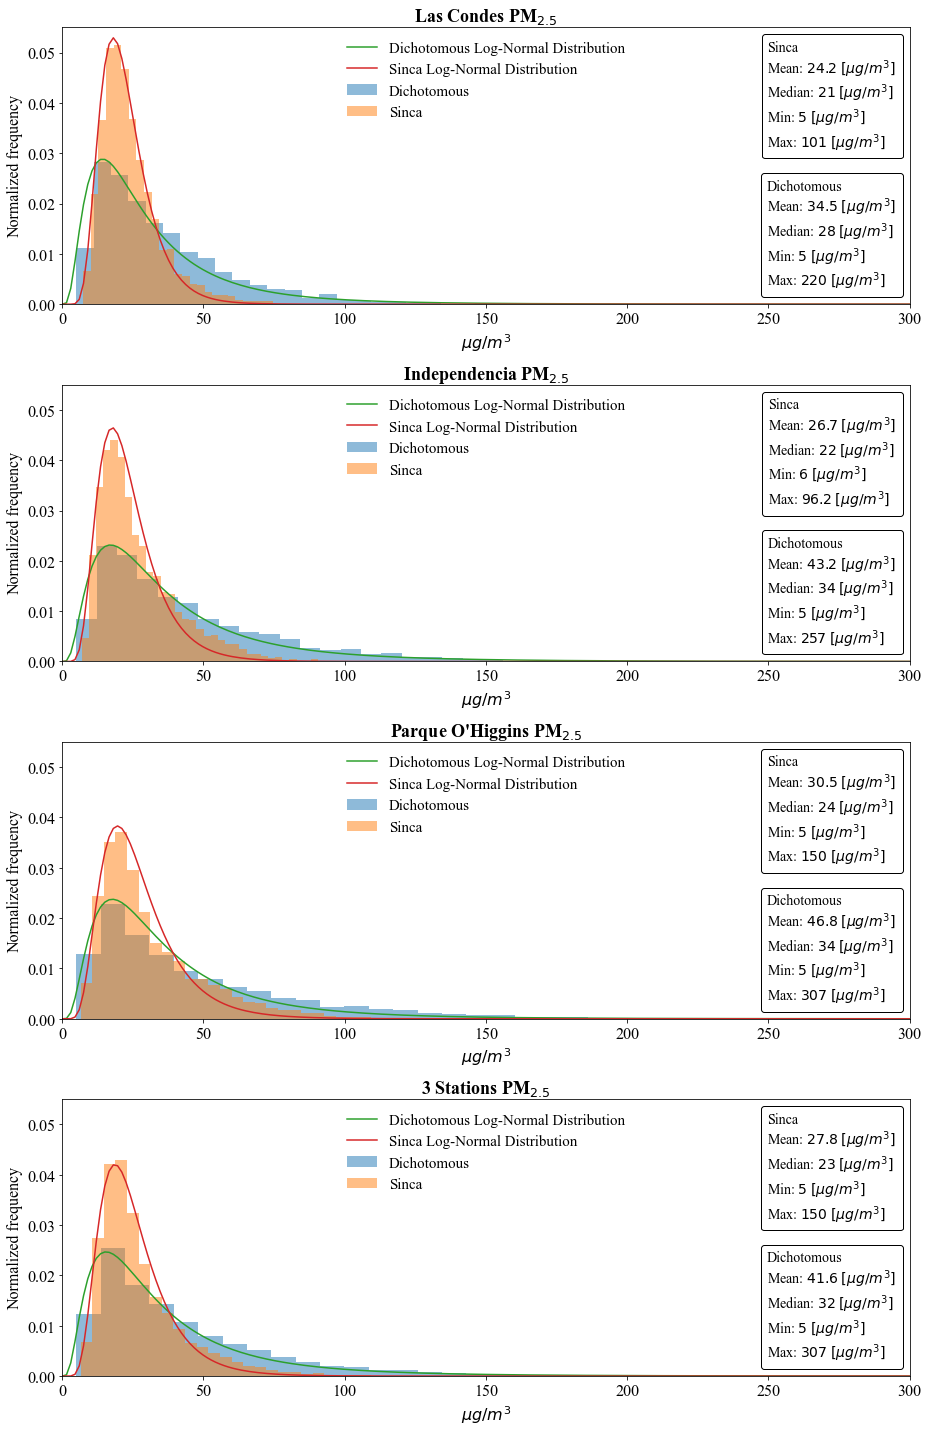

In [58]:

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(13,20))

########################################################

bla1 = plt.subplot(411)
df.PM25_EMM.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
LC.PM25.hist(bins=35,density=1, label='Sinca', alpha= 0.5)
#fig,ax= plt.subplots(figsize=(13.9,5))

at = AnchoredText(
    "Sinca\nMean: $24.2$ $[\mu g/m^{3}]$ \nMedian: $21$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $101$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla1.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $34.5$ $[\mu g/m^{3}]$ \nMedian: $28$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $220$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla1.add_artist(at1)

sigma = df.PM25_EMM.std()**0.5/6.5
mu    = df.PM25_EMM.mean()/10.8
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')


sigma = LC.PM25.std()**0.5/8.5
mu    = LC.PM25.mean()/8
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')


plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('Las Condes PM$_{2.5}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.055])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)


#########################################################


bla2 = plt.subplot(412)
#fig,ax= plt.subplots(figsize=(13.9,5))
at = AnchoredText(
    "Sinca\nMean: $26.7$ $[\mu g/m^{3}]$ \nMedian: $22$ $[\mu g/m^{3}]$ \nMin: $6$ $[\mu g/m^{3}]$ \nMax: $96.2$ $[\mu g/m^{3}]$",
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla2.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $43.2$ $[\mu g/m^{3}]$ \nMedian: $34$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $257$ $[\mu g/m^{3}]$",
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla2.add_artist(at1)

df.PM25_EMF.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
IN.PM25.hist(bins=35,density=1,label='Sinca', alpha=0.5)

sigma = df.PM25_EMF.std()**0.5/7.3
mu    = df.PM25_EMF.mean()/12.7
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')

sigma = IN.PM25.std()**0.5/8.5
mu    = IN.PM25.mean()/8.8
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')



plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('Independencia PM$_{2.5}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.055])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)

plt.tight_layout()

######################################################

bla3 = plt.subplot(413)
#fig,ax= plt.subplots(figsize=(13.9,5))
at = AnchoredText(
    "Sinca\nMean: $30.5$ $[\mu g/m^{3}]$ \nMedian: $24$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $150$ $[\mu g/m^{3}]$",
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla3.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $46.8$ $[\mu g/m^{3}]$ \nMedian: $34$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $307$ $[\mu g/m^{3}]$",
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla3.add_artist(at1)

df.PM25_EMN.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
PO.PM25.hist(bins=35,density=1,label='Sinca', alpha=0.5)

sigma = df.PM25_EMN.std()**0.5/8.5
mu    = df.PM25_EMN.mean()/13.8
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')


sigma = PO.PM25.std()**0.5/9
mu    = PO.PM25.mean()/9.7
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('Parque O\'Higgins PM$_{2.5}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.055])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)

#######################################################


bla4 = plt.subplot(414)
#fig,ax= plt.subplots(figsize=(12,5)) 
at = AnchoredText(
"Sinca\nMean: $27.8$ $[\mu g/m^{3}]$ \nMedian: $23$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $150$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla4.add_artist(at)
at1 = AnchoredText(
"Dichotomous\nMean: $41.6$ $[\mu g/m^{3}]$ \nMedian: $32$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $307$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla4.add_artist(at1)


dico25.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
sinca25.hist(bins=35,density=1, label='Sinca', alpha= 0.5)

sigma = dico25.std()**0.5/7.3
mu    = dico25.mean()/12.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')

sigma = sinca25.std()**0.5/8.5
mu    = sinca25.mean()/8.8
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('3 Stations PM$_{2.5}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.055])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)

plt.tight_layout()

<Figure size 792x1116 with 0 Axes>

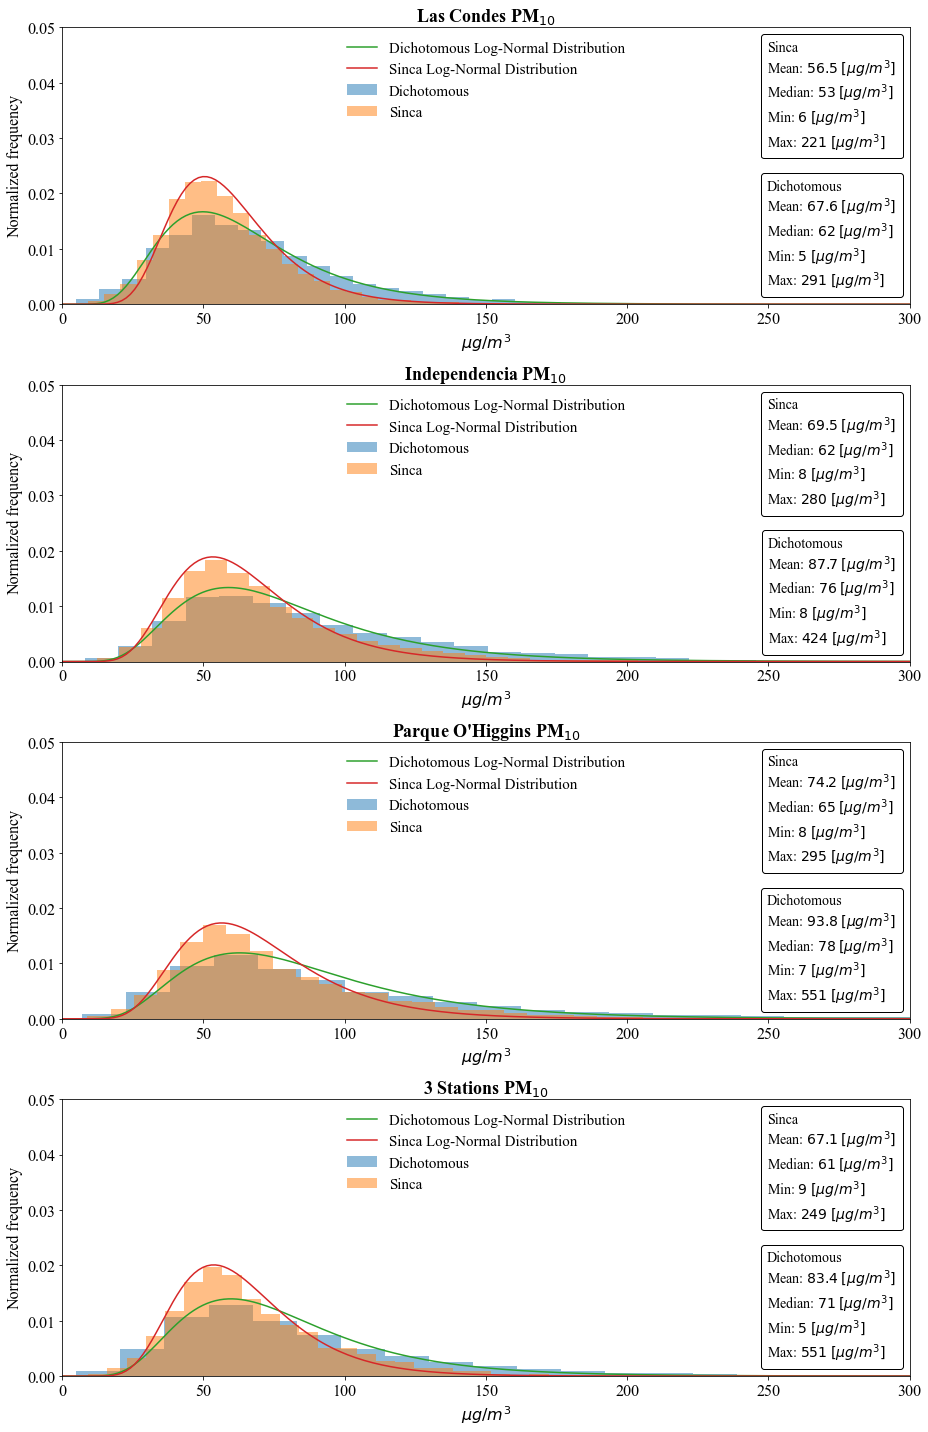

In [59]:
plt.figure(figsize=(11,15.5))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(13,20))

bla1 = plt.subplot(411)
#fig,ax = plt.subplots(figsize=(13.9,5))
at = AnchoredText(
    "Sinca\nMean: $56.5$ $[\mu g/m^{3}]$ \nMedian: $53$ $[\mu g/m^{3}]$ \nMin: $6$ $[\mu g/m^{3}]$ \nMax: $221$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla1.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $67.6$ $[\mu g/m^{3}]$ \nMedian: $62$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $291$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla1.add_artist(at1)

df.PM10_EMM.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
LC.PM10.resample('D').mean().hist(bins=35,density=1, label='Sinca', alpha= 0.5)

sigma = df.PM10_EMM.std()**0.5/13
mu    = df.PM10_EMM.mean()/16.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')


sigma = LC.PM10.std()**0.5/14.3
mu    = LC.PM10.mean()/14.3
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('Las Condes PM$_{10}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.05])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)


##############################################

bla2 = plt.subplot(412)
#fig,ax= plt.subplots(sharey='row',figsize=(13.9,5))
at = AnchoredText(
    "Sinca\nMean: $69.5$ $[\mu g/m^{3}]$ \nMedian: $62$ $[\mu g/m^{3}]$ \nMin: $8$ $[\mu g/m^{3}]$ \nMax: $280$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla2.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $87.7$ $[\mu g/m^{3}]$ \nMedian: $76$ $[\mu g/m^{3}]$ \nMin: $8$ $[\mu g/m^{3}]$ \nMax: $424$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla2.add_artist(at1)

df.PM10_EMF.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
IN.PM10.resample('D').mean().hist(bins=35,density=1,label='Sinca', alpha=0.5)

sigma = df.PM10_EMF.std()**0.5/15
mu    = df.PM10_EMF.mean()/20.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')


sigma = IN.PM10.std()**0.5/15
mu    = IN.PM10.mean()/17
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('Independencia PM$_{10}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.05])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)



################################################
bla3 = plt.subplot(413)
#fig,ax= plt.subplots(figsize=(13.9,5)) 
at = AnchoredText(
    "Sinca\nMean: $74.2$ $[\mu g/m^{3}]$ \nMedian: $65$ $[\mu g/m^{3}]$ \nMin: $8$ $[\mu g/m^{3}]$ \nMax: $295$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla3.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $93.8$ $[\mu g/m^{3}]$ \nMedian: $78$ $[\mu g/m^{3}]$ \nMin: $7$ $[\mu g/m^{3}]$ \nMax: $551$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla3.add_artist(at1)

df.PM10_EMN.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
PO.PM10.resample('D').mean().hist(bins=35,density=1,label='Sinca', alpha=0.5)

sigma = df.PM10_EMN.std()**0.5/16
mu    = df.PM10_EMN.mean()/21.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')

sigma = PO.PM10.std()**0.5/15.8
mu    = PO.PM10.mean()/18
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15,loc='upper center', frameon= False)
plt.title('Parque O\'Higgins PM$_{10}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.05])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)



##################################################
bla4 = plt.subplot(414)
#fig,ax= plt.subplots(figsize=(12,5)) 
at = AnchoredText(
    "Sinca\nMean: $67.1$ $[\mu g/m^{3}]$ \nMedian: $61$ $[\mu g/m^{3}]$ \nMin: $9$ $[\mu g/m^{3}]$ \nMax: $249$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla4.add_artist(at)
at1 = AnchoredText(
    "Dichotomous\nMean: $83.4$ $[\mu g/m^{3}]$ \nMedian: $71$ $[\mu g/m^{3}]$ \nMin: $5$ $[\mu g/m^{3}]$ \nMax: $551$ $[\mu g/m^{3}]$", 
                  prop=dict(size=14), loc='lower right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
bla4.add_artist(at1)

dico10.hist(bins=35,density=1, label='Dichotomous', alpha= 0.5)
sinca10.resample('D').mean().hist(bins=35,density=1, label='Sinca', alpha= 0.5)

sigma = dico10.std()**0.5/16
mu    = dico10.mean()/19.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Dichotomous Log-Normal Distribution')

sigma = sinca10.std()**0.5/16
mu    = sinca10.mean()/16.5
x = np.linspace(0.01, 300, 200) 

pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))  / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, label = 'Sinca Log-Normal Distribution')

plt.legend(fontsize=15, loc='upper center', frameon= False)
plt.title('3 Stations PM$_{10}$', fontsize=18,fontweight="bold")
plt.xlim([0,300])
plt.ylim([0,0.05])
plt.grid(False)
plt.xlabel('$\mu g/m^{3}$',fontsize=16)
plt.ylabel('Normalized frequency',fontsize=16)

plt.tight_layout()

In [60]:
def lineal(x):
    return x

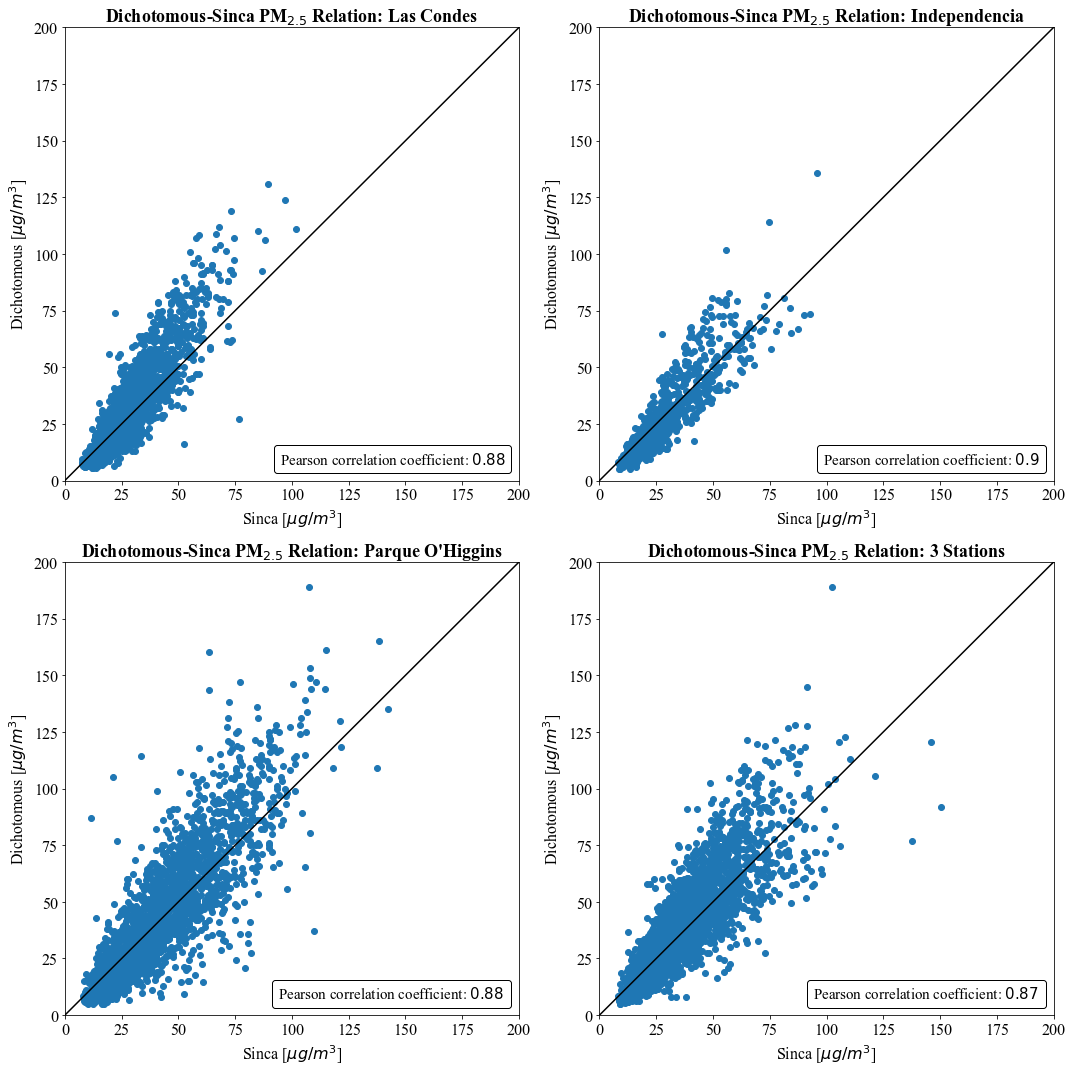

In [61]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

x= np.linspace(0,250,100)
y = lineal(x)

plt.figure(figsize=(15,15))

f = plt.subplot(221)
plt.scatter(LC.PM25.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM25_EMM.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.88$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{2.5}$ Relation: Las Condes', fontsize=18,fontweight="bold")
plt.xlim([0,200])
plt.ylim([0,200])

##########################################################

f = plt.subplot(222)
plt.scatter(IN.PM25.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM25_EMF.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.9$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{2.5}$ Relation: Independencia', fontsize=18,fontweight="bold")
plt.xlim([0,200])
plt.ylim([0,200])

###########################################################

f = plt.subplot(223)
plt.scatter(PO.PM25.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM25_EMN.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.88$ ', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{2.5}$ Relation: Parque O\'Higgins', fontsize=18,fontweight="bold")
plt.xlim([0,200])
plt.ylim([0,200])


###########################################

f = plt.subplot(224)
plt.scatter(sinca25.loc['2000':'2019'].resample('D').mean()[0:-1],dico25.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.87$ ', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{2.5}$ Relation: 3 Stations', fontsize=18,fontweight="bold")
plt.xlim([0,200])
plt.ylim([0,200])


plt.tight_layout()


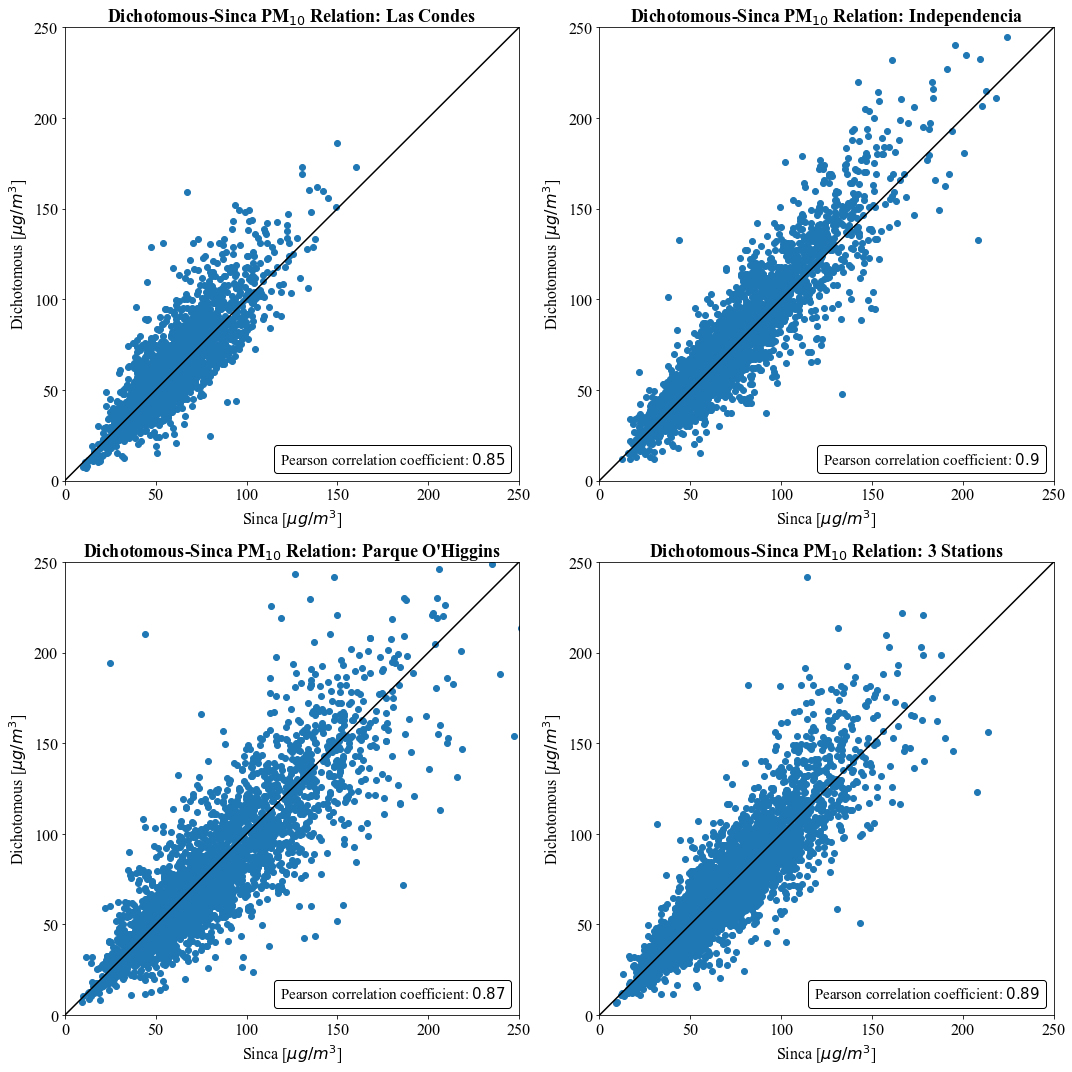

In [62]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16


plt.figure(figsize=(15,15))

f = plt.subplot(221)
plt.scatter(LC.PM10.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM10_EMM.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.85$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{10}$ Relation: Las Condes', fontsize=18,fontweight="bold")
plt.xlim([0,250])
plt.ylim([0,250])

###########################

f = plt.subplot(222)
plt.scatter(IN.PM10.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM10_EMF.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.9$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{10}$ Relation: Independencia', fontsize=18,fontweight="bold")
plt.xlim([0,250])
plt.ylim([0,250])

###############################

f = plt.subplot(223)
plt.scatter(PO.PM10.loc['2000':'2019'].resample('D').mean()[0:-1],df.PM10_EMN.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.87$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{10}$ Relation: Parque O\'Higgins', fontsize=18,fontweight="bold")
plt.xlim([0,250])
plt.ylim([0,250])

################################


f = plt.subplot(224)
plt.scatter(sinca10.loc['2000':'2019'].resample('D').mean()[0:-1],dico10.loc['2000':'2019'].resample('D').mean())
plt.plot(x,y,color='k')

at = AnchoredText('Pearson correlation coefficient: $0.89$', prop=dict(size=15), loc='lower right', frameon= True)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
f.add_artist(at)

plt.xlabel('Sinca [$\mu g/m^{3}$]', fontsize=16)
plt.ylabel('Dichotomous [$\mu g/m^{3}$]', fontsize=16)
plt.title('Dichotomous-Sinca PM$_{10}$ Relation: 3 Stations', fontsize=18,fontweight="bold")
plt.xlim([0,250])
plt.ylim([0,250])


plt.tight_layout()

In [63]:
def model(t, coeffs):
    return  coeffs[0] + coeffs[1]*t + coeffs[2]*np.sin(2*np.pi*t/12) + coeffs[3]*np.cos(2*np.pi*t/12) + coeffs[4]*np.sin(4*np.pi*t/12) + coeffs[5]*np.cos(4*np.pi*t/12) 


def residuals(coeffs, y, t):
    return y - model(t, coeffs)

In [71]:
def series_tiempo(df_sinca, df_dico, sust, stname):
    if sust == 'PM25':
        lab = 'PM$_{2.5}$'
        if stname == 'Las Condes':
            df_dico = df_dico.PM25_EMM
            df_sinca = df_sinca.PM25.loc['2000':'2020']
        if stname == 'Parque O\'Higgins':
            df_dico = df_dico.PM25_EMN
            df_sinca = df_sinca.PM25.loc['2000':'2020']
        if stname == 'Independencia':
            df_dico = df_dico.PM25_EMF
            df_sinca = df_sinca.PM25.loc['2009':'2020']
            
    if sust == 'PM10':
        lab = 'PM$_{10}$'
        df_sinca = df_sinca.PM10
        if stname == 'Las Condes':
            df_dico = df_dico.PM10_EMM
        if stname == 'Parque O\'Higgins':
            df_dico = df_dico.PM10_EMN
        if stname == 'Independencia':
            df_dico = df_dico.PM10_EMF
    
    plt.figure(figsize=(13,7))
    plt.plot(df_dico,'-o', label = lab + ' Dichotomous')
    plt.plot(df_sinca,'-*', label = lab + ' Sinca')

    
    plt.title('24h averaged ' + lab + ' samples of '+ stname + ', SINCA & Dichotomous', fontsize=18,fontweight="bold")
    plt.xlabel('Date [yr]', fontsize=16)
    plt.ylabel('Concentration [$\mu g/m^{3}$]', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()
    return #t_dico, t_sinca

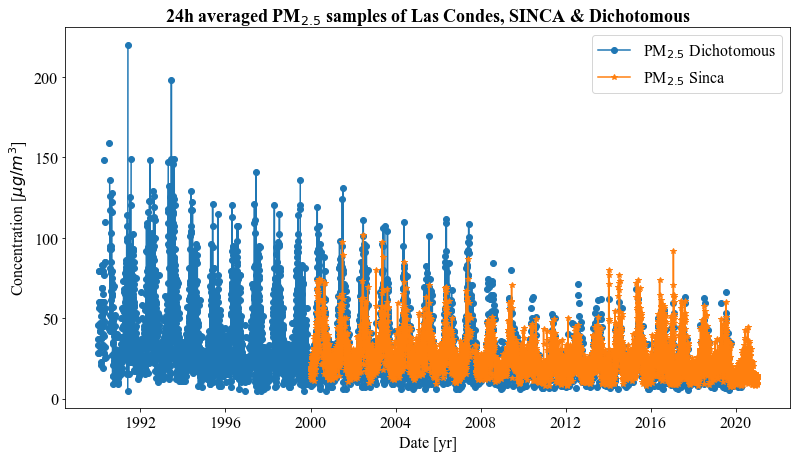

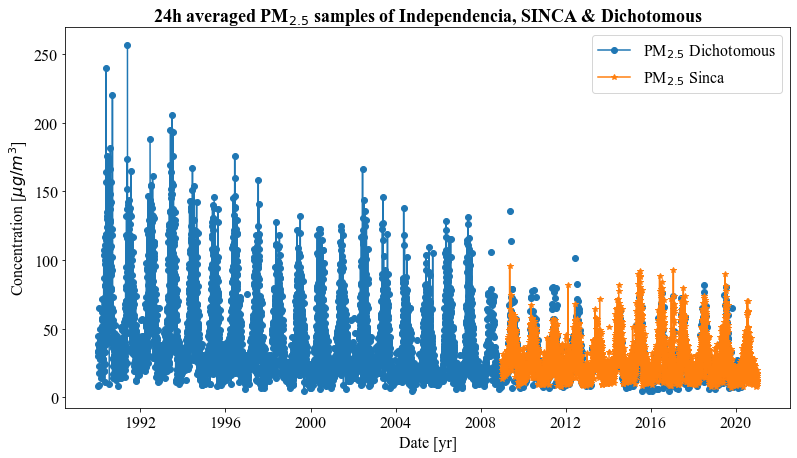

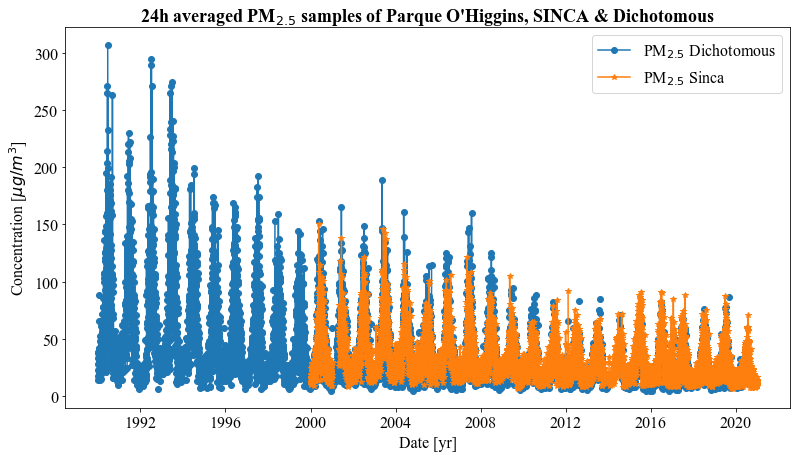

In [84]:
# series temporales de ambas bases de datos para PM25
series_tiempo(LC,df,'PM25','Las Condes')
series_tiempo(IN,df,'PM25','Independencia')
series_tiempo(PO,df,'PM25','Parque O\'Higgins')

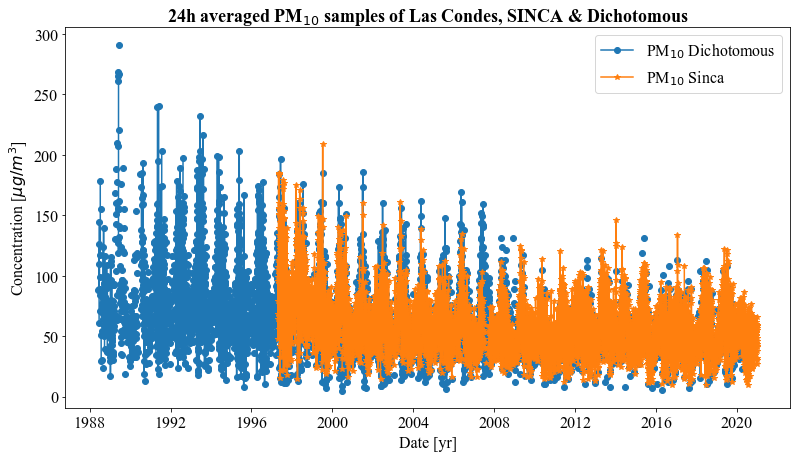

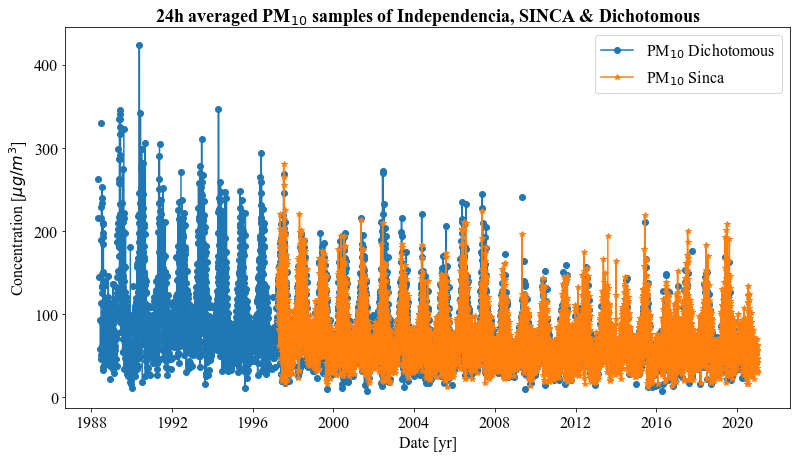

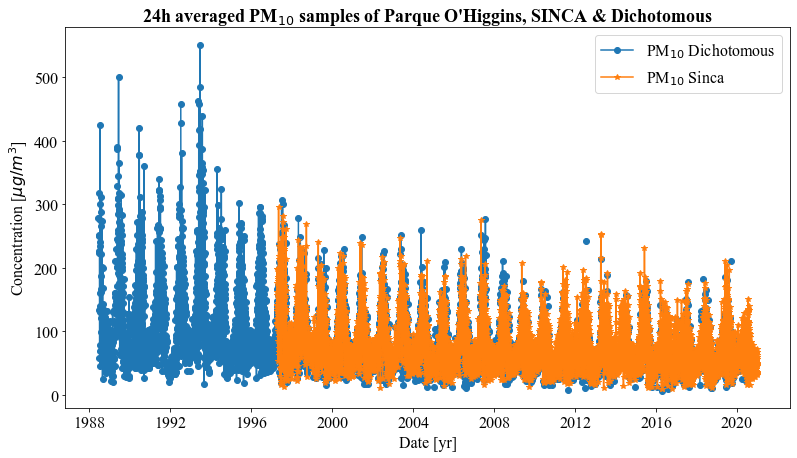

In [85]:
# series temporales de ambas bases de datos para PM10
series_tiempo(LC,df,'PM10','Las Condes')
series_tiempo(IN,df,'PM10','Independencia')
series_tiempo(PO,df,'PM10','Parque O\'Higgins')

In [69]:
def tendencia(df_sinca, df_dico, sust, stname):
    if sust == 'PM25':
        lab = 'PM$_{2.5}$'
        if stname == 'Las Condes':
            df_dico = df_dico.PM25_EMM
            df_sinca = df_sinca.PM25.loc['2000':'2020']
        if stname == 'Parque O\'Higgins':
            df_dico = df_dico.PM25_EMN
            df_sinca = df_sinca.PM25.loc['2000':'2020']
        if stname == 'Independencia':
            df_dico = df_dico.PM25_EMF
            df_sinca = df_sinca.PM25.loc['2009':'2020']
            
    if sust == 'PM10':
        lab = 'PM$_{10}$'
        df_sinca = df_sinca.PM10
        if stname == 'Las Condes':
            df_dico = df_dico.PM10_EMM
        if stname == 'Parque O\'Higgins':
            df_dico = df_dico.PM10_EMN
        if stname == 'Independencia':
            df_dico = df_dico.PM10_EMF
            
    ########## DICO ##########   
    x0 = np.array([1, 1 ,1, 1,1 ,1 ], dtype=float)
    pu_m      = df_dico.resample('M').mean()
    pu_m_aux  = pu_m.fillna(pu_m.mean())
    t_m = np.arange(len(pu_m))
    x_m, flag_m = leastsq(residuals, x0, args=(pu_m_aux.values, t_m))
    
    ######## SINCA ############
    pu_n      = df_sinca.resample('M').mean()
    pu_n_aux  = pu_n.fillna(pu_n.mean())
    t_n = np.arange(len(pu_n))
    x_n, flag_n = leastsq(residuals, x0, args=(pu_n_aux.values, t_n))
    
            
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16

    plt.figure(figsize=(10,10))
    plt.subplot(311)
    seasonal_m = x_m[2]*np.sin(2*np.pi*t_m/12)
    plt.plot(pu_m.index, seasonal_m, label = 'Dichotomous')
    seasonal_n = x_n[2]*np.sin(2*np.pi*t_n/12)
    plt.plot(pu_n.index, seasonal_n, label = 'Sinca')
    
    plt.title('Seasonal Component '+ lab + ' ' +  stname + ' Station',  fontsize=18)
    plt.xlabel('Time [yr]', fontsize = 16)
    plt.ylabel('Concentration [$\mu g/m^{3}$]', fontsize=16)
    plt.legend(fontsize=16, loc='upper left')
    
    ###########################################
    
    f2 = plt.subplot(312)
    lineal_m = x_m[1]*t_m
    plt.plot(pu_m.index, lineal_m, label = 'Dichotomous')
    lineal_n = x_n[1]*t_n
    plt.plot(pu_n.index, lineal_n, label = 'Sinca')
    
    trend_m = str((x_m[1]*120).round(1))          # tendencia decadal dichotomous
    trend_n = str((x_n[1]*120).round(1))          # tendencia decadal sinca
    at = AnchoredText("Decadal trend Dichotomous: "+trend_m+' [$\mu$ g/$m^{3}$/decade]'+'\nDecadal trend Sinca: '+trend_n+' [$\mu$ g/$m^{3}$/decade]', 
                      prop=dict(size=14), loc='lower left', frameon= False)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    f2.add_artist(at)
    
    plt.title('Linear Trend Component '+ lab + ' ' +  stname + ' Station',  fontsize=18)
    plt.xlabel('Time [yr]', fontsize = 16)
    plt.ylabel('Concentration [$\mu g/m^{3}$]', fontsize=16)
    plt.legend(fontsize=16, loc='upper left')
    
    ###########################################
    
    plt.subplot(313)
    R_m = residuals(x_m, pu_m_aux.values, t_m)
    plt.plot(pu_m.index, R_m, '.', label = 'Dichotomous')
    R_n = residuals(x_n, pu_n_aux.values, t_n)
    plt.plot(pu_n.index, R_n, '.', label = 'Sinca')
    
    plt.title('Residual Component '+ lab + ' ' +  stname + ' Station',  fontsize=18)
    plt.xlabel('Time [yr]', fontsize = 16)
    plt.ylabel('Concentration [$\mu g/m^{3}$]', fontsize=16)
    plt.legend(fontsize=16, loc='upper left')
    
    plt.tight_layout()

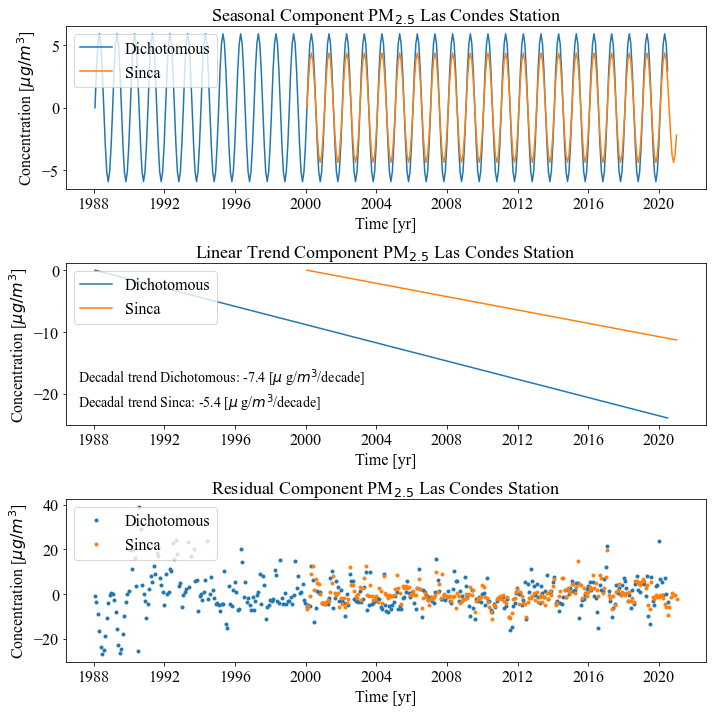

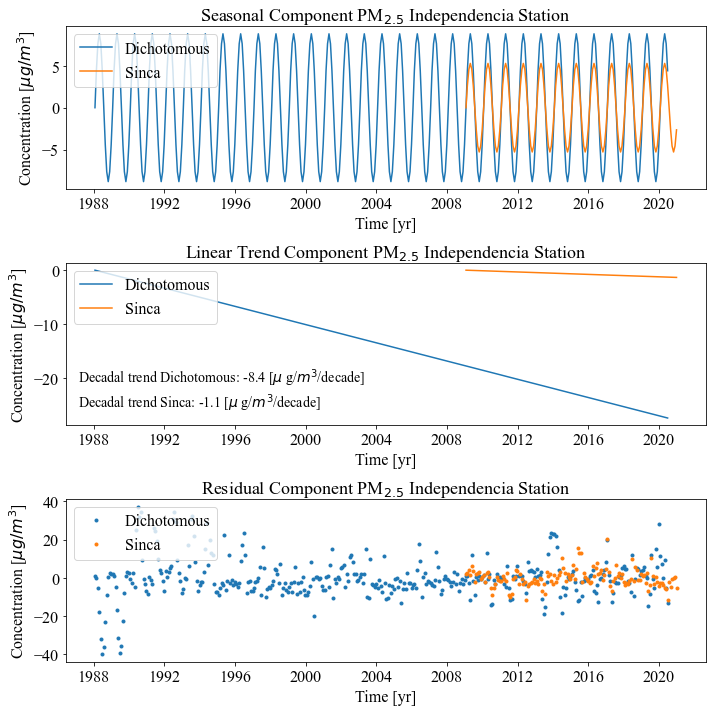

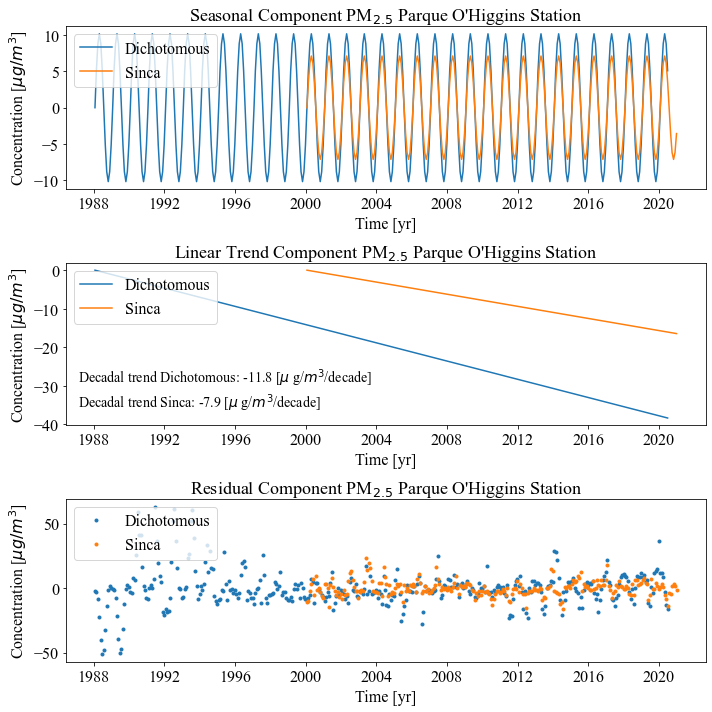

In [82]:
# tendencias PM25 
tendencia(LC, df, 'PM25', 'Las Condes')
tendencia(IN, df, 'PM25', 'Independencia')
tendencia(PO, df, 'PM25', 'Parque O\'Higgins')

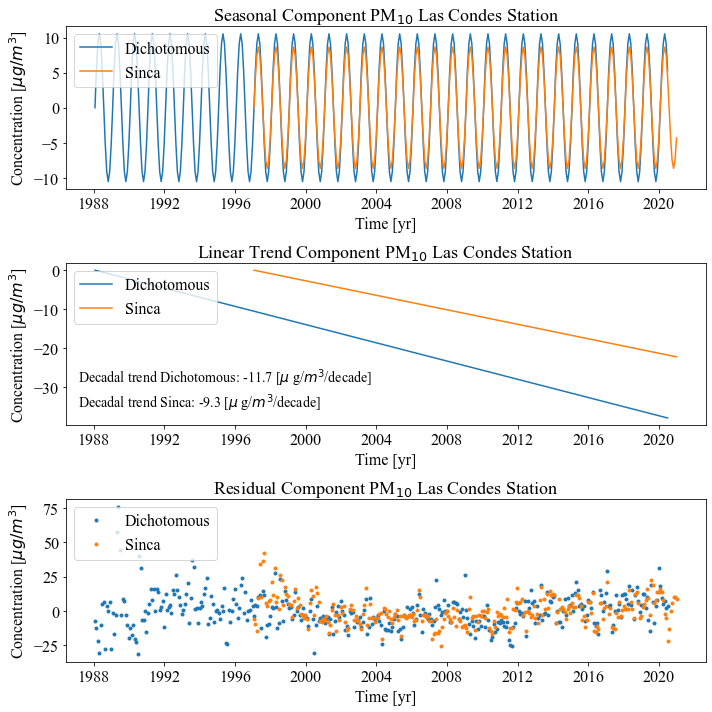

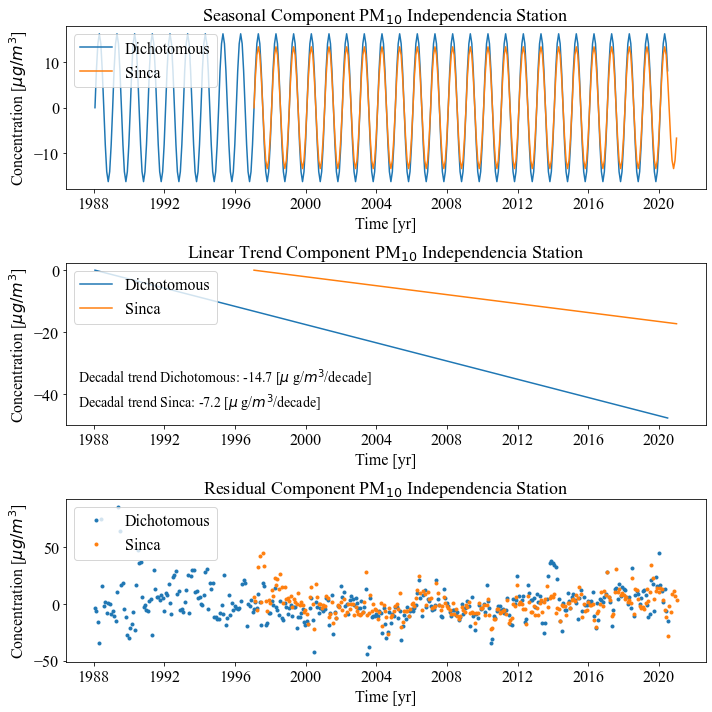

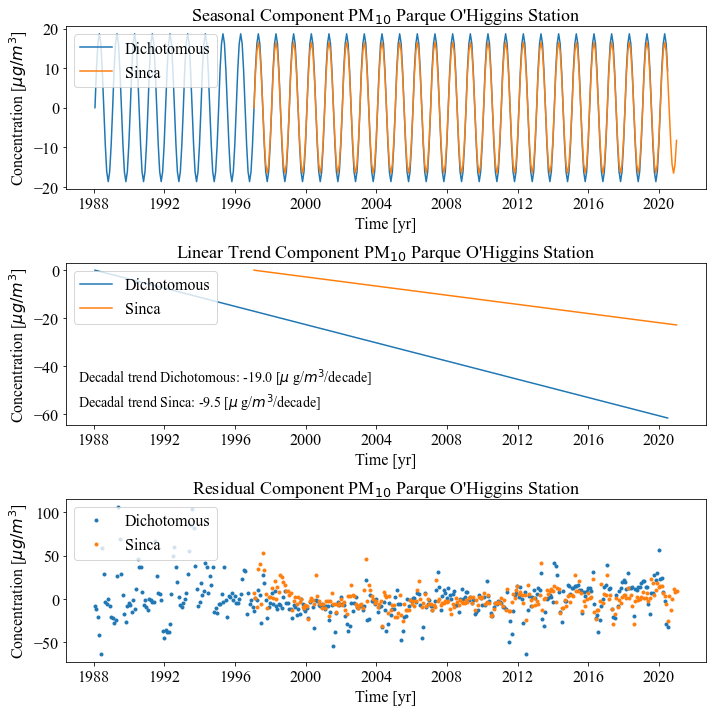

In [83]:
# tendencias PM10
tendencia(LC, df, 'PM10', 'Las Condes')
tendencia(IN, df, 'PM10', 'Independencia')
tendencia(PO, df, 'PM10', 'Parque O\'Higgins')

In [33]:
def tiao(mod,obs) : 
    """
    Tiao et al 1990 https://doi.org/10.1029/JD095iD12p20507
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    
    def autocorr(x):
        x = pd.Series(x)
        n = len(x)
        variance = x.var()
        x = x-x.mean()
        r = np.correlate(x, x, mode = 'full')[-n:]
        result = r/(variance*(np.arange(n, 0, -1)))
        return result

    
    residuo = obs - mod
    Tiao  = (1-autocorr(mod)[1])**(-1/2)*np.std(residuo)*0.023/12      
    
    return Tiao

In [73]:
def err(df):
    "df : dataframe de estación y sustancia que se quiera calcular el error. ej : df = IN.PM25 "
    pu_m      = df.resample('M').mean()
    pu_m_aux  = pu_m.fillna(pu_m.mean())

    x0 = np.array([1, 1 ,1, 1,1 ,1 ], dtype=float)

    t = np.arange(len(pu_m))
    x, flag = leastsq(residuals, x0, args=(pu_m_aux.values, t))

    mod = model(t,x)
    obs = pu_m

    return (tiao(mod,obs)*120).round(1)

In [74]:
err(IN.PM25)

3.6

In [75]:
sinca25 = sinca25.to_frame() 
sinca10 = sinca10.to_frame()
dico25= dico25.to_frame()
dico10= dico10.to_frame()

sinca25 = sinca25.rename(columns={'PM25': 'sinca_PM25'})
dico25 = dico25.rename(columns={0: 'dico_PM25'})
sinca10 = sinca10.rename(columns={'PM10': 'sinca_PM10'})
dico10 = dico10.rename(columns={0: 'dico_PM10'})

sinca25 = sinca25.resample('D').mean()
dico25 = dico25.resample('D').mean()
sinca10 = sinca10.resample('D').mean()
dico10 = dico10.resample('D').mean()

In [76]:
Df = pd.concat([sinca25,sinca10,dico25,dico10], axis =1,)
Df.corr('pearson')

,sinca_PM25,sinca_PM10,dico_PM25,dico_PM10
sinca_PM25,1.000000,0.852674,0.874527,0.823428
sinca_PM10,0.852674,1.000000,0.792234,0.896637
dico_PM25,0.874527,0.792234,1.000000,0.938008
dico_PM10,0.823428,0.896637,0.938008,1.000000


In [77]:
LC = LC.rename(columns={'PM25': 'LC_PM25', 'PM10' : 'LC_PM10'})
IN = IN.rename(columns={'PM25': 'IN_PM25', 'PM10' : 'IN_PM10'})
PO = PO.rename(columns={'PM25': 'PO_PM25', 'PM10' : 'PO_PM10'})

df_sinca = pd.concat([LC,IN,PO], axis=1)

Df = pd.concat([df, df_sinca], axis=1,)
Df.corr('pearson')

,PM25_EMF,PM10_EMF,PM25_EMN,PM10_EMN,PM25_EMM,PM10_EMM,LC_PM25,LC_PM10,IN_PM25,IN_PM10,PO_PM25,PO_PM10
PM25_EMF,1.000000,0.941834,0.918640,0.859895,0.798666,0.734939,0.792956,0.650269,0.900632,0.826306,0.895186,0.788081
PM10_EMF,0.941834,1.000000,0.865761,0.871533,0.719015,0.759989,0.725343,0.705677,0.886703,0.916232,0.869657,0.857874
PM25_EMN,0.918640,0.865761,1.000000,0.944363,0.719424,0.644706,0.725994,0.601527,0.856135,0.786324,0.880892,0.779312
PM10_EMN,0.859895,0.871533,0.944363,1.000000,0.638250,0.653177,0.635779,0.651819,0.778270,0.854755,0.841993,0.872832
PM25_EMM,0.798666,0.719015,0.719424,0.638250,1.000000,0.905548,0.888894,0.700431,0.714527,0.632271,0.700154,0.566816
PM10_EMM,0.734939,0.759989,0.644706,0.653177,0.905548,1.000000,0.871657,0.855037,0.641097,0.717130,0.639940,0.635332
LC_PM25,0.792956,0.725343,0.725994,0.635779,0.888894,0.871657,1.000000,0.752203,0.793478,0.649614,0.758381,0.576462
LC_PM10,0.650269,0.705677,0.601527,0.651819,0.700431,0.855037,0.752203,1.000000,0.533722,0.738912,0.567371,0.677397
IN_PM25,0.900632,0.886703,0.856135,0.778270,0.714527,0.641097,0.793478,0.533722,1.000000,0.847654,0.950388,0.754961
IN_PM10,0.826306,0.916232,0.786324,0.854755,0.632271,0.717130,0.649614,0.738912,0.847654,1.000000,0.858054,0.915607
